In [2]:
import pandas as pd
import numpy as np
import datetime as dt
from datetime import datetime
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

<h4>Load data</h4>

In [3]:
# load improvements data (has year built)
improvements_df = pd.read_csv('data/improvements.csv')

# load electricity consumption data
kwh_address_df = pd.read_csv('data/GRU_Customer_Electric_Consumption.csv')

# load permit data
permit_df = pd.read_csv('data/Building_Permits.csv')

<h4>Drop duplicate Parcel rows with no year built value

In [4]:
# remove duplicate rows with the same Parcel
improvements_df = improvements_df.drop_duplicates(subset=['Parcel'], keep='first')

In [5]:
improvements_df.columns

Index(['Parcel', 'prop_id', 'TaxYear', 'Imprv_ID', 'Imprv_Type', 'Imprv_Desc',
       'Effective_YrBlt', 'Actual_YrBlt', 'Bldg_Num', 'Heated_SquareFeet',
       'Stories'],
      dtype='object')

In [6]:
permit_df.columns

Index(['Permit', 'Classification', 'Parcel Number', 'Contractor Last Name',
       'Contractor First Name', 'Business', 'Primary Party', 'Submit', 'Issue',
       'Address', 'Longitude', 'Latitude', 'Location', 'Location (city)',
       'Location (state)'],
      dtype='object')

<h4>Groupby address in kwh consumption df and aggregate by mean kwh consumption</h4>

In [7]:
# select numerical features 
df_address_kwh = kwh_address_df[['Service Address', 'KWH Consumption', 'Date', 'Latitude', 'Longitude']]

In [8]:
df_address_kwh_index = df_address_kwh.set_index('Service Address')

In [11]:
# groupby address and aggregate by mean kwh consumption of each address
grouped_address = df_address_kwh[['Service Address', 'KWH Consumption']].groupby('Service Address')['KWH Consumption'].agg('mean')

In [12]:
# convert grouped_address to a df
grouped_address = grouped_address.to_frame()

#### Rejoin to include lat and long

In [57]:
# join consumption df with original df to include lat and long
grouped_address_ll = grouped_address.join(df_address_kwh_index, how='left', lsuffix='Service Address', rsuffix='Service Address')

In [58]:
# remove address as index
grouped_address_ll = grouped_address_ll.reset_index()

In [59]:
# remove duplicate observations for the same address
grouped_address_ll = grouped_address_ll.drop_duplicates(subset=['Service Address'], keep='first')

<h4>Merge improvements and permit dataframes on parcel number</h4>

In [61]:

# merge improvements and parcel dataframes on parcel id
df_prop_id = pd.merge(permit_df, improvements_df, how='inner', left_on='Parcel Number', right_on='Parcel')


In [226]:
# 86,235 improvements_df
# 12,366 permit_df
# 12,203 df_prop_id
# 100,313 grouped_address_11

<h4>Merge improvements / permits df with electricity consumption df</h4>

In [62]:
df_prop_id = df_prop_id.set_index('Address')

In [63]:
grouped_address_ll.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100313 entries, 0 to 9291096
Data columns (total 6 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Service Address                 100313 non-null  object 
 1   KWH ConsumptionService Address  100313 non-null  float64
 2   KWH ConsumptionService Address  100306 non-null  float64
 3   Date                            100313 non-null  object 
 4   Latitude                        100313 non-null  float64
 5   Longitude                       100313 non-null  float64
dtypes: float64(4), object(2)
memory usage: 5.4+ MB


In [64]:
# merge permits/imrpovements dataframe with electricity consumption df on lat and long
df_kwh_prop_id = pd.merge(df_prop_id, grouped_address_ll, how='inner', left_on=['Address'], right_on=['Service Address'])

In [65]:
# select numerical features 
df_kwh_prop_num = df_kwh_prop_id[['Service Address', 'KWH ConsumptionService Address', 'KWH ConsumptionService Address', 'Latitude_x', 'Longitude_x', 'Parcel Number', 'prop_id', 'Effective_YrBlt', 'Heated_SquareFeet', 'Stories']]


In [45]:
# make address index
# df_kwh_prop_num = df_kwh_prop_num.set_index('Service Address')
# df_kwh_prop_num.head()

In [71]:
# # convert date column to datetime
# df_kwh_prop_num['Date'] = pd.to_datetime(df_kwh_prop_num['Date'])

In [66]:
# drop repeated columns
df_kwh_prop_num = df_kwh_prop_num.loc[:, ~df_kwh_prop_num.columns.duplicated()]

In [67]:
df_kwh_prop_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10838 entries, 0 to 10837
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Service Address                 10838 non-null  object 
 1   KWH ConsumptionService Address  10838 non-null  float64
 2   Latitude_x                      10838 non-null  float64
 3   Longitude_x                     10838 non-null  float64
 4   Parcel Number                   10838 non-null  object 
 5   prop_id                         10838 non-null  int64  
 6   Effective_YrBlt                 10795 non-null  float64
 7   Heated_SquareFeet               10795 non-null  float64
 8   Stories                         10795 non-null  float64
dtypes: float64(6), int64(1), object(2)
memory usage: 846.7+ KB


In [471]:
# df_kwh_prop_num = df_kwh_prop_num.drop(columns=['LATITUDE', 'LONGITUDE'])

In [49]:
# #reset index to address
# df_kwh_prop_num = df_kwh_prop_num.set_index('Service Address')

In [68]:
# rename kwh column
df_kwh_prop_num = df_kwh_prop_num.rename(columns={'KWH ConsumptionService Address': 'avg_kwh'})

In [69]:
df_kwh_prop_num.describe()

,avg_kwh,Latitude_x,Longitude_x,prop_id,Effective_YrBlt,Heated_SquareFeet,Stories
count,1.083800e+04,10838.000000,10838.000000,10838.000000,10795.000000,10795.000000,10795.000000
mean,3.671487e+03,29.668489,-82.355934,61141.730670,1985.250579,5286.335063,1.227235
std,2.753000e+04,0.026774,0.029987,19772.177616,10.355499,23628.662513,0.566137
min,0.000000e+00,29.600763,-82.449689,30107.000000,1900.000000,1.000000,1.000000
25%,6.141441e+02,29.651957,-82.379326,41110.000000,1978.000000,1266.000000,1.000000
50%,8.392524e+02,29.668118,-82.361523,57498.000000,1984.000000,1708.000000,1.000000
75%,1.228148e+03,29.687321,-82.334802,79373.500000,1993.000000,2587.000000,1.000000
max,1.057792e+06,29.735946,-82.258350,105280.000000,2019.000000,266422.000000,5.000000


In [70]:
df_kwh_prop_num_copy = df_kwh_prop_num
df_kwh_prop_num_copy = df_kwh_prop_num_copy.dropna()

In [71]:
df_kwh_prop_num_copy = df_kwh_prop_num_copy.reset_index()

<H2>EDA</h2>

In [72]:
buildings_year = df_kwh_prop_num_copy[['Effective_YrBlt', 'Service Address']].groupby('Effective_YrBlt').agg('count')

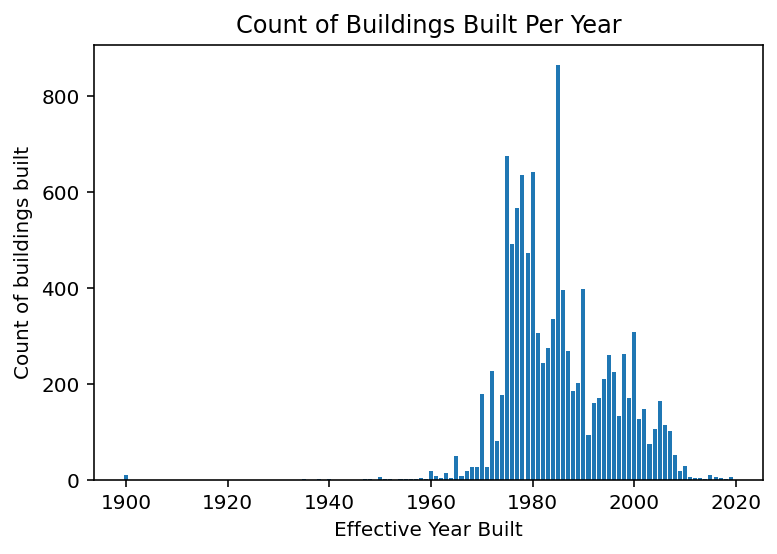

In [74]:
# count of buildings for each year

x = buildings_year.index

fig, ax = plt.subplots()

ax.bar(x, buildings_year['Service Address'])
ax.set_title('Count of Buildings Built Per Year')
ax.set_xlabel('Effective Year Built')
ax.set_ylabel('Count of buildings built')
plt.savefig('images/building_count_by_year.png')

<h4>Create a feature for avg kwh / heated square feet</H4>

In [75]:
df_kwh_prop_num_copy['kwh_per_sqft'] = df_kwh_prop_num_copy['avg_kwh'] / df_kwh_prop_num_copy['Heated_SquareFeet']


In [534]:
# df_kwh_prop_num_copy_ol = df_kwh_prop_num_copy_ol.drop(columns ='kwh_sqft')

In [76]:
df_kwh_prop_num_copy.describe()

,index,avg_kwh,Latitude_x,Longitude_x,prop_id,Effective_YrBlt,Heated_SquareFeet,Stories,kwh_per_sqft
count,10795.000000,1.079500e+04,10795.000000,10795.000000,10795.000000,10795.000000,10795.000000,10795.000000,10795.000000
mean,5423.505975,3.594948e+03,29.668492,-82.355931,61117.447429,1985.250579,5286.335063,1.227235,115.694041
std,3129.658208,2.752341e+04,0.026783,0.029926,19772.162720,10.355499,23628.662513,0.566137,7493.844909
min,0.000000,0.000000e+00,29.600763,-82.449689,30107.000000,1900.000000,1.000000,1.000000,0.000000
25%,2716.500000,6.136699e+02,29.651957,-82.379307,41110.000000,1978.000000,1266.000000,1.000000,0.362735
50%,5426.000000,8.373951e+02,29.668119,-82.361547,57496.000000,1984.000000,1708.000000,1.000000,0.506526
75%,8136.500000,1.222437e+03,29.687272,-82.334806,79370.000000,1993.000000,2587.000000,1.000000,0.692305
max,10837.000000,1.057792e+06,29.735946,-82.258350,94024.000000,2019.000000,266422.000000,5.000000,745121.985455


<h4>Remove outliers due to inaccuracy or being energy intensive industrial facilities</h4>

In [77]:
# delete rows that are outliers due to Heated_SquareFeet = 1 
df_kwh_prop_num_copy = df_kwh_prop_num_copy[df_kwh_prop_num_copy['Heated_SquareFeet'] != 1.0]

# delete rows that are outliers due to being industrial (asphalt producer)
df_kwh_prop_num_copy = df_kwh_prop_num_copy[df_kwh_prop_num_copy['Service Address'] != '2330 NW 73RD PL']

# delete rows that are outliers due to inaccurate Heated_SquareFeet (office building > 900 sq ft)
df_kwh_prop_num_copy = df_kwh_prop_num_copy[df_kwh_prop_num_copy['Service Address'] != '6020 NW 43RD ST']

# delete rows that are outliers due to inaccurate Heated_SquareFeet (Cox Cable > 900 sq ft)
df_kwh_prop_num_copy = df_kwh_prop_num_copy[df_kwh_prop_num_copy['Service Address'] != '2850 NW 43RD ST']

# delete rows that are outliers due to inaccurate Heated_SquareFeet (Shopping center > 1800 sq ft)
df_kwh_prop_num_copy = df_kwh_prop_num_copy[df_kwh_prop_num_copy['Service Address'] != '5200 SW 34TH ST']

# delete rows that are outliers due being industrial manufactures (Milliken & CO flooring)
df_kwh_prop_num_copy = df_kwh_prop_num_copy[df_kwh_prop_num_copy['Service Address'] != '5002 NE 54TH PL']

# delete rows that are outliers due to inaccurate Heated_SquareFeet (medical center > 1100 sq ft)
df_kwh_prop_num_copy = df_kwh_prop_num_copy[df_kwh_prop_num_copy['Service Address'] != '720 SW 2ND AVE']

# delete rows that are outliers due to inaccurate Heated_SquareFeet (super market > 1400 sq ft)
df_kwh_prop_num_copy = df_kwh_prop_num_copy[df_kwh_prop_num_copy['Service Address'] != '3100 SW 35TH BLVD']


<h2>EDA</h2>

<h4>Plot Energy Efficiency Over time</h4>

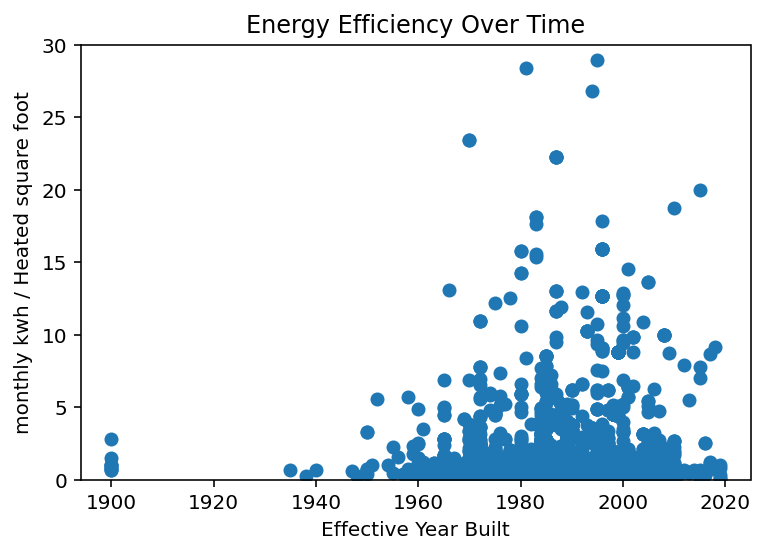

In [79]:
# show avg kwh / heated square feet for each year

x = df_kwh_prop_num_copy['Effective_YrBlt']
y = df_kwh_prop_num_copy['kwh_per_sqft']

fig, ax = plt.subplots()

ax.scatter(x,y)
ax.set_title('Energy Efficiency Over Time')
ax.set_xlabel('Effective Year Built')
ax.set_ylabel('monthly kwh / Heated square foot')
ax.set_ylim([0,30])
plt.savefig('images/efficiency_over_time.png')

<h4>Create a feature for building code release years</h4>

In [80]:
# Convert effective year built into an integer
df_kwh_prop_num_copy['Effective_YrBlt'] = df_kwh_prop_num_copy['Effective_YrBlt'].astype(int)
type(df_kwh_prop_num_copy['Effective_YrBlt'][3])

numpy.int64

In [81]:
# Remove - from parcel number
df_kwh_prop_num_copy['Parcel Number'] = df_kwh_prop_num_copy['Parcel Number'].str.replace('-','')

# Convert Parcel Number into an integer
df_kwh_prop_num_copy['Parcel Number'] = df_kwh_prop_num_copy['Parcel Number'].astype(int)
type(df_kwh_prop_num_copy['Parcel Number'][3])

numpy.int64

In [82]:
# uniform building code release dates - # 31 total
release_years = [1927, 1935, 1937, 1940, 1943, 1946, 1949, 1952, 1955, 1958, 1961, 1964, 1967, 1970, 1973, 1976, 1979, 1982, 1985, 1988, 1991, 1994, 1997, 2000, 2003, 2006, 2009, 2012, 2015, 2018, 2021]
len(release_years)

# generate a feature column with release numbers corresponding to build dates for each address
def release_year_gen(release_num, build_dates): 
    
    # a list of building code release numbers for each effective build date
    release_lst = []

    for date in build_dates: 
        for tup in release_num: 
            #print(date, tup)
            if date < tup[1]:
                release_lst.append(tup[0])
                break 
    
    return release_lst


In [83]:

# create list of years on which new building codes were releases
release_years = [1927, 1935, 1937, 1940, 1943, 1946, 1949, 1952, 1955, 1958, 1961, 1964, 1967, 1970, 1973, 1976, 1979, 1982, 1985, 1988, 1991, 1994, 1997, 2000, 2003, 2006, 2009, 2012, 2015, 2018, 2021]

# create a list of tuples with code release numbers (0-30) with corresponding release year
release_num = [i for i in enumerate(release_years)]

# instantiate a variable for effective year built data
effective_build_dates = df_kwh_prop_num_copy['Effective_YrBlt']

# run release_year_gen function to add code release number to df
releases = release_year_gen(release_num, effective_build_dates)
df_kwh_prop_num_copy['code_release'] = releases

In [198]:
release_num

[(0, 1927),
 (1, 1935),
 (2, 1937),
 (3, 1940),
 (4, 1943),
 (5, 1946),
 (6, 1949),
 (7, 1952),
 (8, 1955),
 (9, 1958),
 (10, 1961),
 (11, 1964),
 (12, 1967),
 (13, 1970),
 (14, 1973),
 (15, 1976),
 (16, 1979),
 (17, 1982),
 (18, 1985),
 (19, 1988),
 (20, 1991),
 (21, 1994),
 (22, 1997),
 (23, 2000),
 (24, 2003),
 (25, 2006),
 (26, 2009),
 (27, 2012),
 (28, 2015),
 (29, 2018),
 (30, 2021)]

In [84]:
# rename lat and long columns
df_kwh_prop_num_copy = df_kwh_prop_num_copy.rename(columns={'Latitude_x': 'Latitude', 'Longitude_x': 'Longitude'})

In [85]:
df_kwh_prop_num_copy.head()

,index,Service Address,avg_kwh,Latitude,Longitude,Parcel Number,prop_id,Effective_YrBlt,Heated_SquareFeet,Stories,kwh_per_sqft,code_release
0,0,2629 NW 55TH BLVD,726.077670,29.705149,-82.361609,6014021030,32391,1977,1498.0,1.0,0.484698,16
1,1,2928 NW 22ND ST,2758.873786,29.679885,-82.353693,9004018000,78433,1984,2971.0,1.0,0.928601,18
2,2,2928 NW 22ND ST,2758.873786,29.679885,-82.353693,9004018000,78433,1984,2971.0,1.0,0.928601,18
3,3,2928 NW 22ND ST,2758.873786,29.679885,-82.353693,9004018000,78433,1984,2971.0,1.0,0.928601,18
4,4,2928 NW 22ND ST,2758.873786,29.679885,-82.353693,9004017000,78432,2010,1222.0,2.0,2.257671,27


<H4>Export cleaned data</H4>

In [86]:
# export clean data to the clean data dir for use in regression model training
df_kwh_prop_num_copy.to_csv(r'clean-data/kwh_year.csv', header=True)